In [27]:
######importing libraries for data manipulation#######
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import math
from PIL import Image
import requests
from io import BytesIO
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import fbeta_score,precision_score,f1_score,recall_score,accuracy_score
from sklearn.linear_model import Perceptron
#from spark_sklearn import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
#import mord
from time import time
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as st
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import turicreate

In [248]:
###############Function definitions###########

#########Function definitions for separating related feature########
def change_vals_new_col(s,value,new_cols):
    
    if(value.get(s) != None):
        if((type(value[s]) == float) and np.isnan(value[s])):
            new_cols[s] = np.nan
        else:
            new_cols.get(s).append(value[s])
    else:
        new_cols.get(s).append(np.nan)
    

def generate_new_cols(related):
    
    new_cols = {'also_bought':[], 'also_viewed':[],'bought_together':[],'buy_after_viewing':[]}
    
    for key,value in related.items():
        if((type(value) == float) and np.isnan(value)):
            
            new_cols['also_bought'].append(np.nan)
            new_cols['also_viewed'].append(np.nan)
            new_cols['bought_together'].append(np.nan)
            new_cols['buy_after_viewing'].append(np.nan)
        else:
            change_vals_new_col('also_bought',value,new_cols)
            change_vals_new_col('also_viewed',value,new_cols)
            change_vals_new_col('bought_together',value,new_cols)
            change_vals_new_col('buy_after_viewing',value,new_cols)
            
        
    return new_cols
#####Function definitions for separating related feature ends####

def plot_related_prods(related,which,final_metadata):
    
    if(related == None):
        print('People who'+str(related)+'this product did not buy any other product:')
        return
    else:
        #print(np.array(related) in final_metadata.index)
        tot = 0
        for idx in related:
            if(idx in final_metadata.index):
                tot += 1
        print(tot)
        tot = round(tot/2)
        print('final',tot)
        f, axes = plt.subplots(tot,tot,figsize=(4,4),dpi=300)
        f.suptitle('People also '+str(which))
        for i in range(0,tot):
            for j in range(0,tot):
                curr_asin = related[i+j]
                if((curr_asin in final_metadata.index) == True):
                    curr_url = final_metadata.loc[curr_asin]['imUrl']
                    curr_title = final_metadata.loc[curr_asin]['title']
                    curr_title = curr_title[0:30]
                    response = requests.get(curr_url)
                    img = Image.open(BytesIO(response.content))
                    axes[i,j].imshow(img)
                    axes[i,j].get_xaxis().set_ticks([])
                    axes[i,j].get_yaxis().set_ticks([])
                    plt.axis('off')
                    axes[i,j].set_title(curr_title,size=3)
        plt.show()            

def Show_related_products(meta_data_row,final_metadata):
    
    #print(meta_data_row)
    curr_url = meta_data_row['imUrl']
    #curr_prod_id = meta_data_row['asin']
    title = meta_data_row['title']
    
    print('The current product is:',title)
    response = requests.get(curr_url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.show()
    
    ####People who bought this product also bought####
    also_bought = meta_data_row['also_bought']
    if((type(also_bought) == float) and np.isnan(also_bought)):
        also_bought = None
    else:
        if(len(also_bought) > 9):
            also_bought = also_bought[0:9]
    plot_related_prods(also_bought,'bought',final_metadata)
    
    ####People who bought this product also viewed####
    also_viewed = meta_data_row['also_viewed']
    if((type(also_viewed) == float) and np.isnan(also_viewed)):
        also_viewed = None
    else:
        if(len(also_viewed) > 9):
            also_viewed = also_viewed[0:9]
    plot_related_prods(also_viewed,'viewed',final_metadata)


def most_popular_products(data,rec_data,recommend,s1 = None):
    
    train_data = turicreate.SFrame(rec_data)
    rev_id = list(data.sample(1,random_state=393)['reviewerID'])
    if(s1 == None):
        popularity_model = turicreate.popularity_recommender.create(train_data, user_id='reviewerID', item_id='asin', target='overall_binary')
    else:
        popularity_model = turicreate.popularity_recommender.create(train_data, user_id='reviewerID', item_id='asin', target='predicted_binary')
    
    popularity_recomm = popularity_model.recommend(users=rev_id,k=recommend)
    popularity_recomm.print_rows(num_rows=25)
    
    if(s1 == None):
        path_list = ['Popularity_real/']
    else:
        path_list = ['Popularity_pred/']
        
    l = list(popularity_recomm[popularity_recomm['reviewerID'] == rev_id[0]]['asin'])
    for i in range(len(l)):
        all_ratings = data[data['asin'] == l[i]]['overall']
        mean_rating = np.mean(all_ratings)
        title = final_metadata.loc[l[i],'title']+'| mean rating: '+str(np.round(mean_rating,decimals=2))+'| rank:'+str(i+1)
        curr_url = final_metadata.loc[l[i],'imUrl']
        response = requests.get(curr_url)
        img = Image.open(BytesIO(response.content))
        plt.title(title)
        plt.imshow(img)
        s = title.split('/')
        final_title = ''
        for i in range(len(s)):
            final_title = final_title + ' '+s[i]
                
        heading = final_title +'.png'
        final_path = path_list[0]+heading
        plt.savefig(final_path,dpi=300)
        plt.show()
    
    
def Collaborative_filtering(data,rec_data,recommend,s1=None):
    
    train_data = turicreate.SFrame(rec_data)
    rev_id = list(data.sample(3,random_state=333)['reviewerID'])
    
    if(s1 == None):
        item_sim_model = turicreate.item_similarity_recommender.create(train_data, user_id='reviewerID', item_id='asin', target='overall_binary', similarity_type='cosine')
    else:
        item_sim_model = turicreate.item_similarity_recommender.create(train_data, user_id='reviewerID', item_id='asin', target='predicted_binary', similarity_type='cosine')
    
    item_sim_recomm = item_sim_model.recommend(users=rev_id,k=recommend)
    item_sim_recomm.print_rows(num_rows=25)
    
    
    if(s1 == None):
        path_list = ['user_1_photos/','user_2_photos/','user_3_photos/','user_4_photos/','user_5_photos/']
        path_list_rec = ['user_1_rec/','user_2_rec/','user_3_rec/','user_4_rec/','user_5_rec/']
    else:
        path_list = ['user_11_photos/','user_22_photos/','user_33_photos/','user_44_photos/','user_55_photos/']
        path_list_rec = ['user_11_rec/','user_22_rec/','user_33_rec/','user_44_rec/','user_55_rec/']
    
    
    for j in range(len(rev_id)):
        rev_data = data[data['reviewerID'] == rev_id[j]]
        l2 = list(rev_data['asin'])
        for i in range(len(l2)):
            title = final_metadata.loc[l2[i],'title']+' rating: '+str(rev_data.iloc[i,5])
            curr_url = final_metadata.loc[l2[i],'imUrl']
            response = requests.get(curr_url)
            img = Image.open(BytesIO(response.content))
            plt.title(title)
            plt.imshow(img)
            s = title.split('/')
            final_title = ''
            for i in range(len(s)):
                final_title = final_title + ' '+s[i]
                
            heading = final_title+' purchased by '+rev_id[j]+'.png'
            final_path = path_list[j]+heading
            print(final_path)
            plt.savefig(final_path,dpi=300)
            plt.show()
            
        l = list(item_sim_recomm[item_sim_recomm['reviewerID'] == rev_id[j]]['asin'])
        for i in range(len(l)):
            all_ratings = data[data['asin'] == l[i]]['overall']
            mean_rating = np.mean(all_ratings)
            title = final_metadata.loc[l[i],'title']+'| mean rating: '+str(np.round(mean_rating,decimals=2))+'| rank:'+str(i+1)
            curr_url = final_metadata.loc[l[i],'imUrl']
            response = requests.get(curr_url)
            img = Image.open(BytesIO(response.content))
            plt.title(title)
            plt.imshow(img)
            s = title.split('/')
            final_title = ''
            for i in range(len(s)):
                final_title = final_title + ' '+s[i]
                
            heading = final_title +' recommended to'+rev_id[j]+'.png'
            final_path = path_list_rec[j]+heading
            plt.savefig(final_path,dpi=300)
            plt.show()   
    
    
    

# Read Data

In [2]:
#####Reading Data##ata#####
#####This is a smaller data for initial data exploration and model testing#####
######The data is about Heal and Personal care Products on Amazon##########

def parse(path):
    g = open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

data_path = '/Users/ruchinpatel/Desktop/USC_EVERYTHING/SPRINGBOARD/CAPSTONE/Health_and_Personal_Care_5.json'
metadata_path = '/Users/ruchinpatel/Desktop/USC_EVERYTHING/SPRINGBOARD/CAPSTONE/meta_Health_and_Personal_Care.json'

data = getDF(data_path)
metadata = getDF(metadata_path)

In [5]:
########## Generating seperate columns for related feature######
related = metadata['related'].to_dict()
newly_created_columns = pd.DataFrame(generate_new_cols(related))

In [111]:
#########Final Metadata dataframe###########
final_metadata = pd.concat([metadata,newly_created_columns],axis = 1)
final_metadata = final_metadata.drop('related',axis=1)
final_metadata = final_metadata.set_index('asin')

######converting the dates to date time format#####
data['unixReviewTime'] = pd.to_datetime(data['unixReviewTime'],unit='s')
data['reviewTime'] = pd.to_datetime(data['reviewTime'])
replace = {1:0,2:0,3:0,4:1,5:1}
data['overall_binary'] = data[['overall']].replace(to_replace=replace,value=None)

In [168]:
data.head(10)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346355 entries, 0 to 346354
Data columns (total 10 columns):
reviewerID        346355 non-null object
asin              346355 non-null object
reviewerName      343304 non-null object
helpful           346355 non-null object
reviewText        346355 non-null object
overall           346355 non-null float64
summary           346355 non-null object
unixReviewTime    346355 non-null datetime64[ns]
reviewTime        346355 non-null datetime64[ns]
overall_binary    346355 non-null float64
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 39.1+ MB


In [167]:
name = data[data['reviewerID'] == 'ALC5GH8CAMAI7']['reviewerName']
name

0         AnnN
67549     AnnN
73107     AnnN
101342    AnnN
101404    AnnN
105435    AnnN
162430    AnnN
Name: reviewerName, dtype: object

In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346355 entries, 0 to 346354
Data columns (total 10 columns):
reviewerID        346355 non-null object
asin              346355 non-null object
reviewerName      343304 non-null object
helpful           346355 non-null object
reviewText        346355 non-null object
overall           346355 non-null float64
summary           346355 non-null object
unixReviewTime    346355 non-null datetime64[ns]
reviewTime        346355 non-null datetime64[ns]
overall_binary    346355 non-null float64
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 39.1+ MB


In [113]:
final_metadata.head(10)

,description,title,imUrl,salesRank,categories,price,brand,also_bought,also_viewed,bought_together,buy_after_viewing
asin,,,,,,,,,,,
0077614992,This is an example product description.,Principles of Mgmt + Oper-CSUF Custom C,http://ecx.images-amazon.com/images/I/51G%2BRq...,{'Health & Personal Care': 168429},[[Health & Personal Care]],NaN,NaN,"[0471730726, 0132834871, 0471391905, B00000JZK...","[0073525057, 1133227295, 0324628676, 0073523224]",NaN,NaN
0615208479,By now we all know the benefits of exercise fo...,Brain Fitness Exercises Software,http://ecx.images-amazon.com/images/I/41kbZB04...,{'Health & Personal Care': 1346973},"[[Health & Personal Care, Personal Care]]",NaN,NaN,NaN,NaN,NaN,NaN
0615269990,What's wrong with your patient?Do all the symp...,Occam's Razor,http://ecx.images-amazon.com/images/I/51fH-ABe...,{'Toys & Games': 110575},"[[Health & Personal Care, Personal Care, Shavi...",34.99,NaN,"[1935660152, 0071743979, 0071831428, 032308787...","[1594741476, B0069628EU, B009RTGX2Y, B000IQHSL...",NaN,NaN
0615315860,NaN,101 BlenderBottle Recipes Quick and Easy,http://ecx.images-amazon.com/images/I/21zOQu2Q...,{'Health & Personal Care': 254068},[[Health & Personal Care]],NaN,NaN,"[B006VT9RBM, B0010JLMO8, B001CXC69C, B0064QSHX...",[B0018G4ZEW],NaN,NaN
0615406394,This is an example product description.,"Aphrodite Reborn - Women's Stories of Hope, Co...",http://ecx.images-amazon.com/images/I/51rJLgsi...,{'Health & Personal Care': 377936},[[Health & Personal Care]],NaN,NaN,"[0966035232, 1421407205]",NaN,NaN,NaN
0615836828,NaN,Breast Cancer: My Spiritual Journey,http://ecx.images-amazon.com/images/I/41UrGEwA...,{'Health & Personal Care': 603899},[[Health & Personal Care]],NaN,NaN,NaN,NaN,NaN,NaN
0641710577,Foster Grant introduces a whole new dimension ...,Foster Grant Women's Reading Glasses Romance W...,http://ecx.images-amazon.com/images/I/414Fx6sG...,{'Health & Personal Care': 1039561},"[[Health & Personal Care, Personal Care, Eye C...",NaN,NaN,NaN,NaN,NaN,NaN
0641864507,* Super bright LED light\n * 2 CR2016 repla...,LED Travel Magnifier,http://ecx.images-amazon.com/images/I/41ZlfiUd...,NaN,"[[Health & Personal Care, Medical Supplies & E...",NaN,UltraOptix,NaN,"[B002E3KJBG, 1935009656, B00524H98U, B00H8R6G9...",NaN,NaN
0681504498,"Affordably priced. Hardcover or paper back, th...",Itty Bitty Paperback Booklight,http://ecx.images-amazon.com/images/I/31pQu4fW...,NaN,"[[Health & Personal Care, Medical Supplies & E...",21.97,Maxi-Aids,NaN,"[1933622717, B00005R8TK]",NaN,"[1933622717, B00005R8TN, B000PER1DA, B00005R8TL]"


In [114]:
final_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263032 entries, 0077614992 to B00LYPUPZK
Data columns (total 11 columns):
description          237839 non-null object
title                262362 non-null object
imUrl                262767 non-null object
salesRank            247665 non-null object
categories           263032 non-null object
price                196043 non-null float64
brand                124304 non-null object
also_bought          120684 non-null object
also_viewed          193140 non-null object
bought_together      118616 non-null object
buy_after_viewing    5160 non-null object
dtypes: float64(1), object(10)
memory usage: 24.1+ MB


In [9]:
users = data.reviewerID.unique().shape[0]
items = metadata.asin.unique().shape[0]

In [10]:
print(users)
print(items)

38609
263032


In [11]:
for line in data.head(10).itertuples():
    print(line[1])

ALC5GH8CAMAI7
AHKSURW85PJUE
A38RMU1Y5TDP9
A1XZUG7DFXXOS4
A1MS3M7M7AM13X
AXO4PQU0XG3TG
A28X0LT2100RL1
A1VUSWRVN8SJA8
A1JQDCX4LDKBZ3
A3RNRXOM5J2C93


In [12]:
r_index = data.reviewerID.unique()
c_index = data.asin.unique()

In [13]:
d = pd.DataFrame(0, index=r_index, columns=c_index)

In [14]:
for line in data.itertuples():
    d.ix[line[1]].loc[line[2]] = int(line[6])

In [32]:
np.unique(d)

array([0, 1, 2, 3, 4, 5])

In [15]:
d.head(10)

,159985130X,1933622865,1935009656,3812028492,7884890364,B00000J47L,B00000J9DU,B00000JHQ2,B00000JHQ6,B00000JHQC,...,B00L5L7ZPQ,B00L5LSO7E,B00L6FWTJ8,B00L9BRHGY,B00LBE8SMG,B00LDUS8H8,B00LFB2ENY,B00LIASY0Y,B00LJBMCFA,B00LJBMCKK
ALC5GH8CAMAI7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AHKSURW85PJUE,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A38RMU1Y5TDP9,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1XZUG7DFXXOS4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1MS3M7M7AM13X,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AXO4PQU0XG3TG,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A28X0LT2100RL1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1VUSWRVN8SJA8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1JQDCX4LDKBZ3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A3RNRXOM5J2C93,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
##### Using Turi Create#######

In [21]:
#data_temp = data.head(1000)

In [250]:
rec_data = data[['reviewerID','asin','overall','overall_binary']]

Warning: Ignoring columns overall;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 346355 observations with 38609 users and 18534 items.

Data prepared in: 0.725597s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.382ms                        | 2.5        |

| 54.084ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.42s                               | 0                | 0               |

| 7.12s                               | 100              | 18534           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 7.22398s

+----------------+------------+----------------------+------+
|   reviewerID   |    asin    |        score         | rank |
+----------------+------------+----------------------+------+
| A15VFMU0WO8ED2 | B001M5C29O | 0.025220311605013333 |  1   |
| A15VFMU0WO8ED2 | B001U0OP46 | 0.021038284668555625 |  2   |
| A15VFMU0WO8ED2 | B00005UKIB | 0.019230769230769232 |  3   |
| A15VFMU0WO8ED2 | B00067JKH6 | 0.01731208196053138  |  4   |
| A15VFMU0WO8ED2 | B0007N5DNY | 0.017200524990375225 |  5   |
| AVSRLB4QXACSV  | B008RIFNZE | 0.03648096323013306  |  1   |
| AVSRLB4QXACSV  | B001RADQGW | 0.03316164016723633  |  2   |
| AVSRLB4QXACSV  | B009VJ2MX4 | 0.030290208756923676 |  3   |
| AVSRLB4QXACSV  | B00APE29KK |  0.027076356112957   |  4   |
| AVSRLB4QXACSV  | B009RCNPYU | 0.023448817431926727 |  5   |
| AV2GFSSHXCODC  | B000GFPD1K | 0.02777778108914693  |  1   |
| AV2GFSSHXCODC  | B0044Z0A34 | 0.02777778108914693  |  2   |
| AV2GFSSHXCODC  | B0002GMGBI | 0.02777778108914693  |  3   |
| AV2GFS

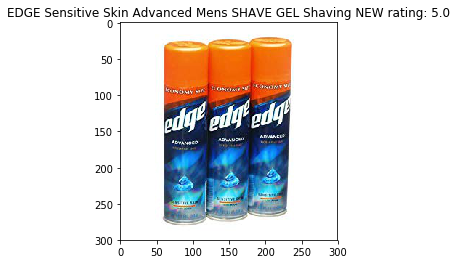

user_1_photos/ Philips Sonicare HX6013 ProResults Brush Head Standard, 3-Pack rating: 5.0 purchased by A15VFMU0WO8ED2.png


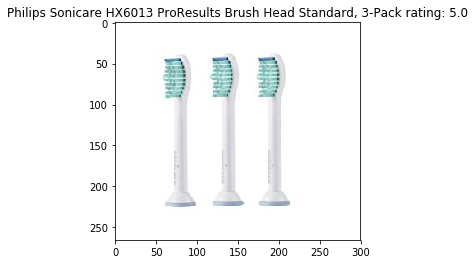

user_1_photos/ Maxell Watch Battery Button Cell SR626SW SR-626SW 377 Pack of 5 Batteries rating: 5.0 purchased by A15VFMU0WO8ED2.png


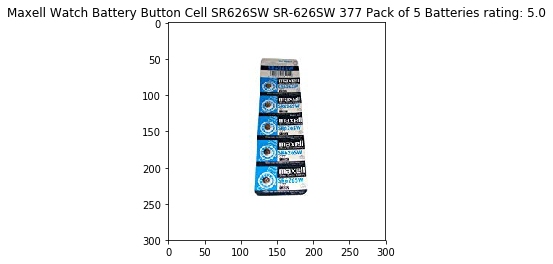

user_1_photos/ Sony Lithium 3V Batteries Size CR2016 (Pack of 5) rating: 5.0 purchased by A15VFMU0WO8ED2.png


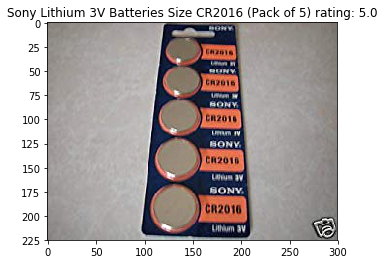

user_1_photos/ Mr. Clean EXTRA POWER Magic Eraser - 10 Count rating: 5.0 purchased by A15VFMU0WO8ED2.png


In [ ]:
Collaborative_filtering(data,rec_data,5)

Preparing data set.

Data has 346355 observations with 38609 users and 18534 items.

Data prepared in: 0.711264s

346355 observations to process; with 18534 unique items.

+---------------+------------+-------+------+
|   reviewerID  |    asin    | score | rank |
+---------------+------------+-------+------+
| ACURG383CP30X | B000050FE2 |  1.0  |  1   |
| ACURG383CP30X | B000050AUD |  1.0  |  2   |
| ACURG383CP30X | B00004Z4EG |  1.0  |  3   |
| ACURG383CP30X | B00004YK1A |  1.0  |  4   |
| ACURG383CP30X | B00004T7UJ |  1.0  |  5   |
| ACURG383CP30X | B00004OCLT |  1.0  |  6   |
| ACURG383CP30X | B00004OCLS |  1.0  |  7   |
| ACURG383CP30X | B00003IE4E |  1.0  |  8   |
| ACURG383CP30X | B00002N88C |  1.0  |  9   |
| ACURG383CP30X | 1935009656 |  1.0  |  10  |
+---------------+------------+-------+------+
[10 rows x 4 columns]



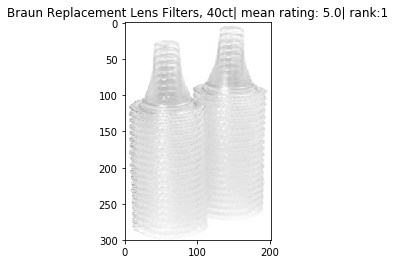

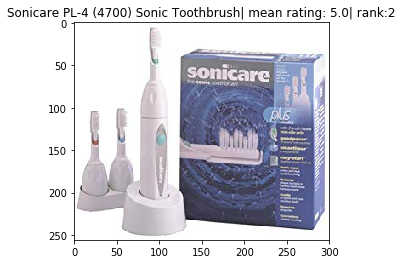

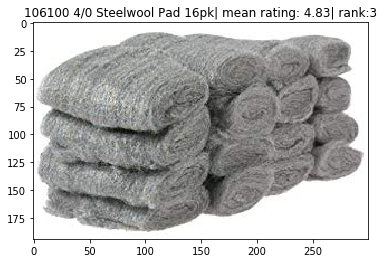

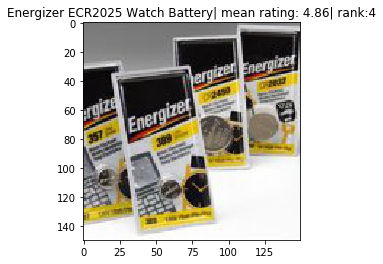

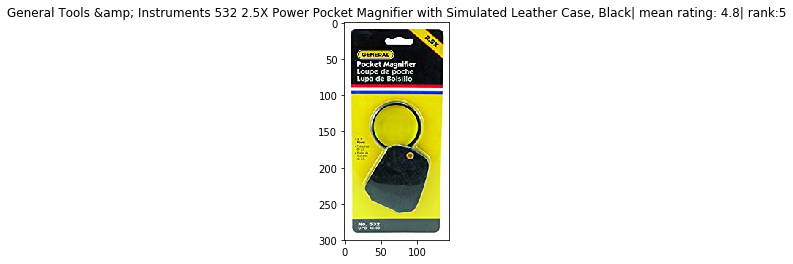

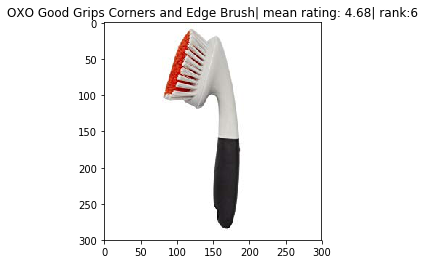

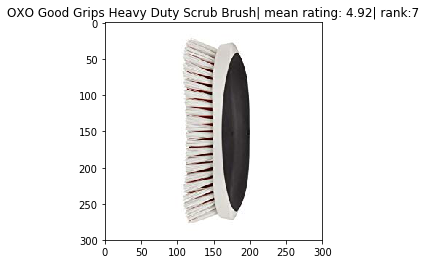

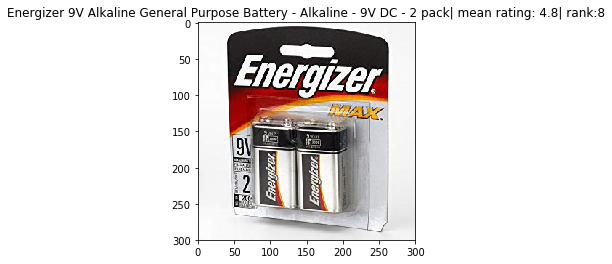

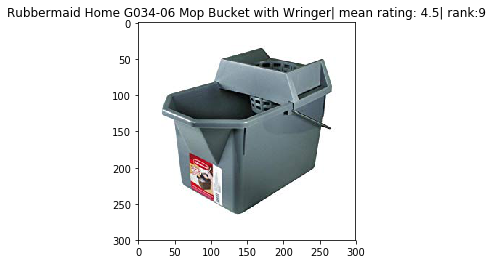

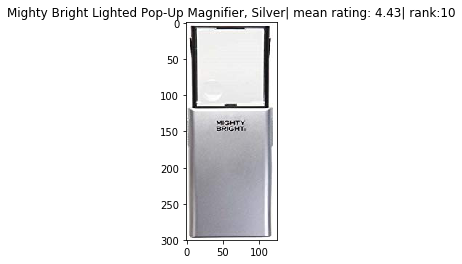

In [249]:
most_popular_products(data,rec_data,10,s1 = None)